#### Renaming Images in Dataset e.g.,1.ا.jpeg

In [11]:
import os
import uuid

base_folder = "../Dataset"

for folder_name in os.listdir(base_folder):
    folder_path = os.path.join(base_folder, folder_name)
    
    if not os.path.isdir(folder_path):
        continue
    
    # Step 1: List all files (skip hidden files) and sort
    files = sorted([f for f in os.listdir(folder_path) if not f.startswith('.')])
    
    temp_mapping = []
    # Step 2: Rename to temporary unique names first
    for file in files:
        old_path = os.path.join(folder_path, file)
        orig_ext = os.path.splitext(file)[1]  # get original extension (.jpg, .png, etc.)
        temp_name = f"temp_{uuid.uuid4().hex}{orig_ext}"  # keep original extension
        temp_path = os.path.join(folder_path, temp_name)
        os.rename(old_path, temp_path)
        temp_mapping.append((temp_name, orig_ext))
    
    # Step 3: Rename temporary files to final safe names
    for i, (temp_file, ext) in enumerate(temp_mapping, start=1):
        final_name = f"{i}.{folder_name}{ext}"
        temp_path = os.path.join(folder_path, temp_file)
        final_path = os.path.join(folder_path, final_name)
        os.rename(temp_path, final_path)
    
    print(f"✅ Safely renamed all files in: {folder_name}")


✅ Safely renamed all files in: ب
✅ Safely renamed all files in: د
✅ Safely renamed all files in: ی
✅ Safely renamed all files in: ن
✅ Safely renamed all files in: س
✅ Safely renamed all files in: ف
✅ Safely renamed all files in: ش
✅ Safely renamed all files in: و
✅ Safely renamed all files in: غ
✅ Safely renamed all files in: چ
✅ Safely renamed all files in: ا
✅ Safely renamed all files in: خ
✅ Safely renamed all files in: ڈ
✅ Safely renamed all files in: ٹ
✅ Safely renamed all files in: ص
✅ Safely renamed all files in: پ
✅ Safely renamed all files in: گ
✅ Safely renamed all files in: ط
✅ Safely renamed all files in: م
✅ Safely renamed all files in: ڑ
✅ Safely renamed all files in: ذ
✅ Safely renamed all files in: ع
✅ Safely renamed all files in: ژ
✅ Safely renamed all files in: ج
✅ Safely renamed all files in: ث
✅ Safely renamed all files in: ے
✅ Safely renamed all files in: ظ
✅ Safely renamed all files in: ل
✅ Safely renamed all files in: ر
✅ Safely renamed all files in: ک
✅ Safely r

#### Import Libraries

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


#### Configuration and Path Setup

In [3]:
BASE_PATH = "../"
DATASET_PATH = os.path.join(BASE_PATH, "Dataset")
PREPROCESSED_PATH = os.path.join(BASE_PATH, "Preprocessed")
AUGMENTED_PATH = os.path.join(BASE_PATH, "Augmented_Dataset")
MODELS_PATH = os.path.join(BASE_PATH, "models")

print("📁 Project Structure:")
print(f"Dataset Path: {DATASET_PATH}")
print(f"Preprocessed Path: {PREPROCESSED_PATH}")
print(f"Augmented Path: {AUGMENTED_PATH}")
print(f"Models Path: {MODELS_PATH}")

📁 Project Structure:
Dataset Path: ../Dataset
Preprocessed Path: ../Preprocessed
Augmented Path: ../Augmented_Dataset
Models Path: ../models


#### Image Preprocessing Function

In [4]:
def preprocess_image(img, save_path=None):
    """
    Preprocess image: resize, threshold, and save if path provided
    """
    # Resize to 128x128
    img_resized = cv2.resize(img, (128, 128))
    
    # Apply binary threshold with Otsu
    _, img_binary = cv2.threshold(img_resized, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Save if path provided
    if save_path:
        cv2.imwrite(save_path, img_binary)
    
    return img_binary


#### Data Augmentation Function (5 copies per image)

In [5]:
def augment_image(img, augment_count=5):
    """
    Create 5 augmented copies of the image
    """
    augmented_images = []
    rows, cols = img.shape
    
    # Define augmentation techniques
    augmentations = []
    
    # Original image (first copy)
    augmented_images.append(img)
    
    # Rotations (2 copies)
    for angle in [-10, 10]:
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        rotated = cv2.warpAffine(img, M, (cols, rows), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        augmented_images.append(rotated)
    
    # Translations (2 copies)
    for dx, dy in [(-3, -3), (3, 3)]:
        M = np.float32([[1, 0, dx], [0, 1, dy]])
        translated = cv2.warpAffine(img, M, (cols, rows), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        augmented_images.append(translated)
    
    # If we need more augmentations, add scaling
    if len(augmented_images) < augment_count:
        # Scaling
        scale_factor = 0.9
        scaled = cv2.resize(img, None, fx=scale_factor, fy=scale_factor)
        # Pad to original size
        pad_x = (cols - scaled.shape[1]) // 2
        pad_y = (rows - scaled.shape[0]) // 2
        scaled_padded = cv2.copyMakeBorder(scaled, pad_y, pad_y, pad_x, pad_x, 
                                         cv2.BORDER_CONSTANT, value=0)
        augmented_images.append(scaled_padded)
    
    # Ensure we have exactly 5 copies
    return augmented_images[:augment_count]

#### Process All Images (Preprocessing + Augmentation)

In [6]:
def process_all_images():
    """
    Process all images: preprocess + create 5 augmented copies
    Returns features and labels for training
    """
    data = []
    labels = []
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    
    print("🔄 Starting image processing and augmentation...")
    
    # Count total images for progress bar
    total_images = 0
    for folder in os.listdir(DATASET_PATH):
        folder_path = os.path.join(DATASET_PATH, folder)
        if os.path.isdir(folder_path):
            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(valid_extensions):
                    total_images += 1
    
    print(f"📊 Total images found: {total_images}")
    
    # Process each image
    processed_count = 0
    for folder in os.listdir(DATASET_PATH):
        folder_path = os.path.join(DATASET_PATH, folder)
        if not os.path.isdir(folder_path):
            continue
        
        print(f"📁 Processing class: {folder}")
        
        # Create directories for preprocessed and augmented images
        preprocessed_class_path = os.path.join(PREPROCESSED_PATH, folder)
        augmented_class_path = os.path.join(AUGMENTED_PATH, folder)
        os.makedirs(preprocessed_class_path, exist_ok=True)
        os.makedirs(augmented_class_path, exist_ok=True)
        
        for img_name in os.listdir(folder_path):
            if not img_name.lower().endswith(valid_extensions):
                continue
            
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if img is None:
                print(f"❌ Skipped invalid image: {img_path}")
                continue
            
            # Preprocess image
            base_name = os.path.splitext(img_name)[0]
            preprocessed_path = os.path.join(preprocessed_class_path, f"{base_name}_preprocessed.jpg")
            preprocessed_img = preprocess_image(img, preprocessed_path)
            
            # Create augmented images (5 copies)
            augmented_images = augment_image(preprocessed_img, 5)
            
            # Process each augmented image
            for i, aug_img in enumerate(augmented_images):
                # Save augmented image
                aug_save_path = os.path.join(augmented_class_path, f"{base_name}_aug_{i+1}.jpg")
                cv2.imwrite(aug_save_path, aug_img)
                
                # Extract HOG features
                try:
                    features = hog(aug_img, 
                                 orientations=12, 
                                 pixels_per_cell=(8, 8), 
                                 cells_per_block=(2, 2), 
                                 block_norm='L2-Hys',
                                 feature_vector=True)
                    data.append(features)
                    labels.append(folder)
                except Exception as e:
                    print(f"❌ Error extracting features from {aug_save_path}: {e}")
                    continue
            
            processed_count += 1
            if processed_count % 50 == 0:
                print(f"✅ Processed {processed_count}/{total_images} images")
    
    print(f"🎉 Image processing complete! Total processed: {processed_count}")
    print(f"📊 Total samples after augmentation: {len(data)}")
    
    return np.array(data), np.array(labels)

####  Execute Image Processing

In [7]:
print("🚀 Starting complete image processing pipeline...")
X, y = process_all_images()

print(f"📦 Final dataset shape: {X.shape}")
print(f"🎯 Number of classes: {len(np.unique(y))}")

🚀 Starting complete image processing pipeline...
🔄 Starting image processing and augmentation...
📊 Total images found: 1020
📁 Processing class: ب
📁 Processing class: د
✅ Processed 50/1020 images
📁 Processing class: ی
📁 Processing class: ن
✅ Processed 100/1020 images
📁 Processing class: س
✅ Processed 150/1020 images
📁 Processing class: ف
📁 Processing class: ش
✅ Processed 200/1020 images
📁 Processing class: و
📁 Processing class: غ
✅ Processed 250/1020 images
📁 Processing class: چ
✅ Processed 300/1020 images
📁 Processing class: ا
📁 Processing class: خ
✅ Processed 350/1020 images
📁 Processing class: ڈ
✅ Processed 400/1020 images
📁 Processing class: ٹ
📁 Processing class: ص
✅ Processed 450/1020 images
📁 Processing class: پ
📁 Processing class: گ
✅ Processed 500/1020 images
📁 Processing class: ط
✅ Processed 550/1020 images
📁 Processing class: م
📁 Processing class: ڑ
✅ Processed 600/1020 images
📁 Processing class: ذ
📁 Processing class: ع
✅ Processed 650/1020 images
📁 Processing class: ژ
✅ Proce

 ##### Encode Labels and Split Data
 Encode string labels to numerical values

In [8]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

print("🔤 Class mapping:")
for i, class_name in enumerate(encoder.classes_):
    print(f"  {class_name} -> {i}.    ",end="")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"📊 Data split:")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Testing samples: {X_test.shape[0]}")



🔤 Class mapping:
  ا -> 0.      ب -> 1.      ت -> 2.      ث -> 3.      ج -> 4.      ح -> 5.      خ -> 6.      د -> 7.      ذ -> 8.      ر -> 9.      س -> 10.      ش -> 11.      ص -> 12.      ض -> 13.      ط -> 14.      ظ -> 15.      ع -> 16.      غ -> 17.      ف -> 18.      ل -> 19.      م -> 20.      ن -> 21.      و -> 22.      ٹ -> 23.      پ -> 24.      چ -> 25.      ڈ -> 26.      ڑ -> 27.      ژ -> 28.      ک -> 29.      گ -> 30.      ی -> 31.      ے -> 32.    📊 Data split:
  Training samples: 4080
  Testing samples: 1020


#### Feature Scaling

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Feature scaling completed!")

✅ Feature scaling completed!


#### SVM Model Training

In [34]:
# ------------------- SVM + Hyperparameter Tuning -------------------
param_grid = {
    'C': [10, 100],
    'gamma': ['scale', 0.001]
}
grid = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=3)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
model = grid.best_estimator_

# ------------------- Evaluation -------------------
y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, model.predict(X_train))

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Accuracy Gap:", train_accuracy - test_accuracy)

Best Parameters: {'C': 10, 'gamma': 'scale'}
Train Accuracy: 1.0
Test Accuracy: 0.7480392156862745
Accuracy Gap: 0.2519607843137255


#### Regularization to reduce overfitting

In [14]:
# ------------------- SVM Training -------------------
model = SVC(
    C=1,           # More regularization
    gamma='scale', 
    kernel='rbf', 
    class_weight='balanced',
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, model.predict(X_train))

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Accuracy Gap:", train_accuracy - test_accuracy)

Train Accuracy: 0.966421568627451
Test Accuracy: 0.6715686274509803
Accuracy Gap: 0.29485294117647065


In [15]:
# ------------------- SVM Training -------------------
model = SVC(
    C=10,           # More regularization
    gamma='scale', 
    kernel='rbf', 
    class_weight='balanced',
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, model.predict(X_train))

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Accuracy Gap:", train_accuracy - test_accuracy)

Train Accuracy: 1.0
Test Accuracy: 0.7480392156862745
Accuracy Gap: 0.2519607843137255


In [17]:
# ------------------- SVM Training -------------------
model = SVC(
    C=50,           # More regularization
    gamma='scale', 
    kernel='rbf', 
    class_weight='balanced',
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, model.predict(X_train))

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Accuracy Gap:", train_accuracy - test_accuracy)

Train Accuracy: 1.0
Test Accuracy: 0.7480392156862745
Accuracy Gap: 0.2519607843137255


In [10]:
# ------------------- SVM with Feature Reduction -------------------
from sklearn.feature_selection import SelectKBest, f_classif

# Reduce to 2000 best features
selector = SelectKBest(f_classif, k=2000)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

print(f"Reduced features: {X_train_reduced.shape[1]}")

model = SVC(
    C=10,
    gamma='scale', 
    kernel='rbf', 
    class_weight='balanced',
    random_state=42
)

model.fit(X_train_reduced, y_train)

y_pred = model.predict(X_test_reduced)
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, model.predict(X_train_reduced))

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Accuracy Gap:", train_accuracy - test_accuracy)

Reduced features: 2000
Train Accuracy: 1.0
Test Accuracy: 0.792156862745098
Accuracy Gap: 0.207843137254902


#### The above model is lowest overfit so I select it for Urdu-Letter-Recognition-System

In [11]:
joblib.dump(model, '../models/final_svm_model.pkl')
joblib.dump(selector, '../models/selector.pkl')

['../models/selector.pkl']

In [25]:
# ------------------- SVM with Feature Reduction -------------------
from sklearn.feature_selection import SelectKBest, f_classif

# Reduce to 2000 best features
selector = SelectKBest(f_classif, k=1500)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

print(f"Reduced features: {X_train_reduced.shape[1]}")

model = SVC(
    C=10,
    gamma='scale', 
    kernel='rbf', 
    class_weight='balanced',
    random_state=42
)

model.fit(X_train_reduced, y_train)

y_pred = model.predict(X_test_reduced)
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, model.predict(X_train_reduced))

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Accuracy Gap:", train_accuracy - test_accuracy)

Reduced features: 1500
Train Accuracy: 1.0
Test Accuracy: 0.7892156862745098
Accuracy Gap: 0.21078431372549022


In [24]:
# ------------------- STRONG REGULARIZATION -------------------
from sklearn.feature_selection import SelectKBest, f_classif

# Reduce to 1000 features only
selector = SelectKBest(f_classif, k=1500)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

print(f"Reduced features: {X_train_reduced.shape[1]}")

# Strong regularization
model = SVC(
    C=0.1,           # Very low C
    gamma='scale',      # Fixed gamma
    kernel='rbf', 
    class_weight='balanced',
    random_state=42
)

model.fit(X_train_reduced, y_train)

y_pred = model.predict(X_test_reduced)
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, model.predict(X_train_reduced))

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Accuracy Gap:", train_accuracy - test_accuracy)

if (train_accuracy - test_accuracy) > 0.1:
    print("🚨 Still overfitting - Accept 79% test accuracy as FINAL")
else:
    print("✅ Good balance achieved!")

Reduced features: 1500
Train Accuracy: 0.5088235294117647
Test Accuracy: 0.36764705882352944
Accuracy Gap: 0.14117647058823524
🚨 Still overfitting - Accept 79% test accuracy as FINAL


In [26]:
# ------------------- KNN Training -------------------
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(
    n_neighbors=5,      # Start with 5 neighbors
    weights='distance',  # Closer neighbors matter more
    metric='euclidean'
)

print("🔍 Training KNN...")
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)
test_accuracy_knn = accuracy_score(y_test, y_pred_knn)
train_accuracy_knn = accuracy_score(y_train, knn.predict(X_train_scaled))

print("KNN Train Accuracy:", train_accuracy_knn)
print("KNN Test Accuracy:", test_accuracy_knn)
print("KNN Accuracy Gap:", train_accuracy_knn - test_accuracy_knn)

🔍 Training KNN...
KNN Train Accuracy: 1.0
KNN Test Accuracy: 0.4647058823529412
KNN Accuracy Gap: 0.5352941176470588


#### ANN Model Training

In [27]:
# ------------------- ANN Training -------------------
from sklearn.neural_network import MLPClassifier

ann_model = MLPClassifier(
    hidden_layer_sizes=(300, 150),  # Smaller architecture
    activation='relu',
    solver='adam',
    alpha=0.1,         # Strong regularization
    batch_size=128,    # Larger batches
    learning_rate='adaptive',
    max_iter=100,      # Fewer iterations
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=5,
    random_state=42
)

print("🧠 Training ANN (15-25 minutes expected)...")
ann_model.fit(X_train_scaled, y_train)

y_pred_ann = ann_model.predict(X_test_scaled)
test_accuracy_ann = accuracy_score(y_test, y_pred_ann)
train_accuracy_ann = accuracy_score(y_train, ann_model.predict(X_train_scaled))

print("ANN Train Accuracy:", train_accuracy_ann)
print("ANN Test Accuracy:", test_accuracy_ann)
print("ANN Accuracy Gap:", train_accuracy_ann - test_accuracy_ann)

🧠 Training ANN (15-25 minutes expected)...
ANN Train Accuracy: 0.9308823529411765
ANN Test Accuracy: 0.6186274509803922
ANN Accuracy Gap: 0.3122549019607843


#### Visuals

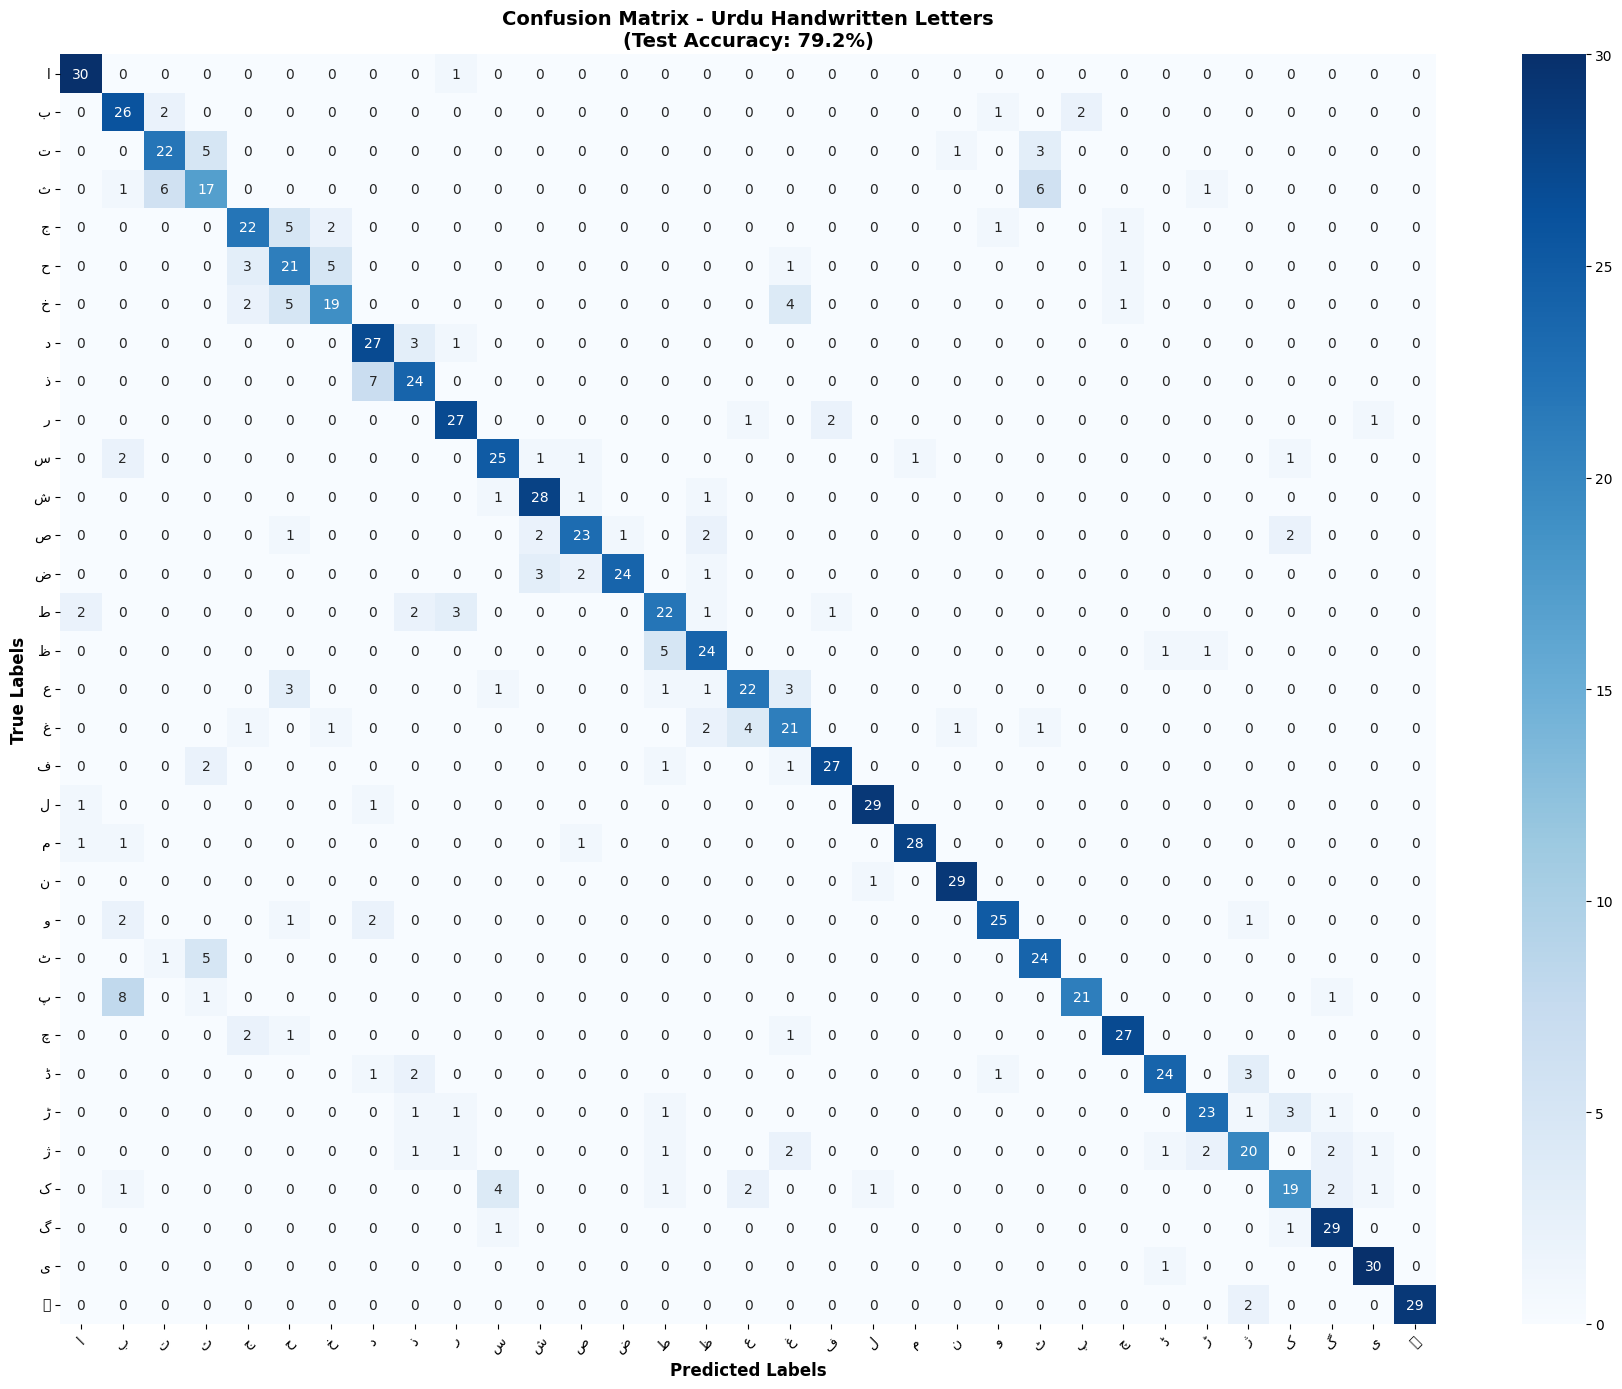

In [32]:
plt.figure(figsize=(18, 14))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=encoder.classes_, 
            yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels', fontsize=12, fontweight='bold')
plt.ylabel('True Labels', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Urdu Handwritten Letters\n(Test Accuracy: 79.2%)', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../results/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

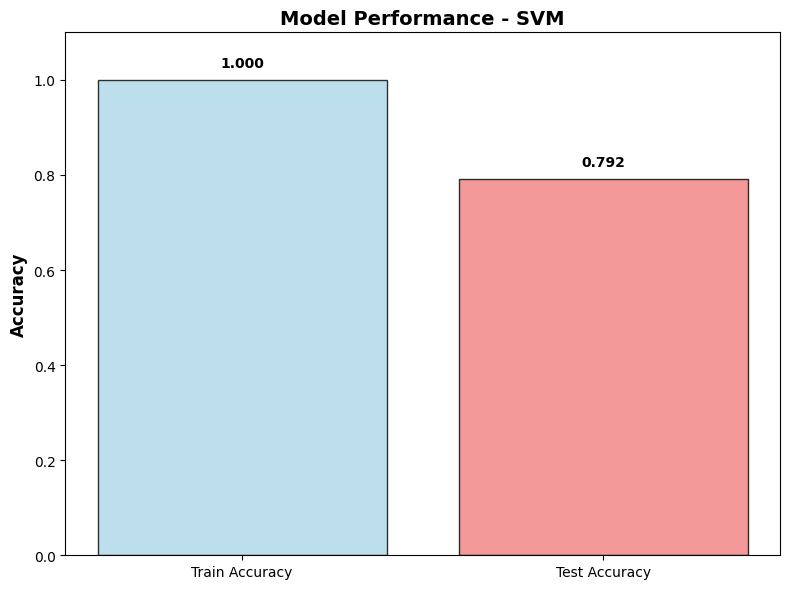

In [33]:
# 2. Simple Accuracy Chart
plt.figure(figsize=(8, 6))
accuracies = [train_accuracy, test_accuracy]
labels = ['Train Accuracy', 'Test Accuracy']
colors = ['lightblue', 'lightcoral']

bars = plt.bar(labels, accuracies, color=colors, edgecolor='black', alpha=0.8)
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Model Performance - SVM', fontsize=14, fontweight='bold')
plt.ylim(0, 1.1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/accuracy_chart.png', dpi=300, bbox_inches='tight')
plt.show()